# Post Processing of MaxQuant output (proteinGroups.txt)

## Import Data

In [449]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [450]:
datafile="D:\proteinGroupsCleaned.txt"  # From Geremy
#datafile="D:\proteinGroups.txt" # My file
df = pd.read_csv(datafile, sep='\t', lineterminator='\r', dtype={"Only identified by site": str, "Reverse": str})

print(df.head())

     Protein IDs Majority protein IDs Peptide counts (all)  \
0  \n1433B_MOUSE          1433B_MOUSE                   25   
1  \n1433E_MOUSE          1433E_MOUSE                   27   
2  \n1433F_MOUSE          1433F_MOUSE                   28   
3  \n1433G_MOUSE          1433G_MOUSE                   23   
4  \n1433S_MOUSE          1433S_MOUSE                   13   

  Peptide counts (razor+unique) Peptide counts (unique)  \
0                            18                      16   
1                            25                      25   
2                            25                      24   
3                            17                      17   
4                            11                      11   

                                       Fasta headers  Number of proteins  \
0  >1433B_MOUSE 14-3-3 protein beta/alpha; AltNam...                 1.0   
1  >1433E_MOUSE 14-3-3 protein epsilon; Short=14-...                 1.0   
2  >1433F_MOUSE 14-3-3 protein eta; Accessio

## Clean Data
* Remove rows corresponding to the proteins only identified by site/Reverse/Potential contaminant
* Remove rows with multiple protein IDs
* Extract separately the LFQ and the iBAQ quantification info


In [451]:
print("Before:", len(df[df['Only identified by site'] == '+']), len(df[df['Reverse'] == '+']), len(df[df['Potential contaminant'] == '+']))

df = df[(df['Only identified by site'] != '+') & (df.Reverse != '+') & (df['Potential contaminant'] != '+')]

print("After:", len(df[df['Only identified by site'] == '+']), len(df[df['Reverse'] == '+']), len(df[df['Potential contaminant'] == '+']))

Before: 13 64 21
After: 0 0 0


In [452]:
### Remove rows with multiple proteinIDs
print("Before:", len(df[df['Majority protein IDs'].str.contains(';', na=False)]))

single_proteinID = df['Majority protein IDs'].str.contains(';')==False
df = df[single_proteinID]

print("After:", len(df[df['Majority protein IDs'].str.contains(';', na=False)]))

Before: 71
After: 0


In [453]:
### Take separate df slices for different quant techniques
LFQ_df = df.filter(regex=("LFQ.*|Majority protein IDs"))
print("***** LFQ_df:\n", LFQ_df.head())

iBAQ_df = df.filter(regex=("iBAQ .*|Majority protein IDs"))
print("\n***** iBAQ_df:\n", iBAQ_df.head())

***** LFQ_df:
   Majority protein IDs  LFQ intensity 04_Liver  LFQ intensity 05_Liver  \
0          1433B_MOUSE            2.093000e+09            1.998200e+09   
1          1433E_MOUSE            3.903200e+09            4.020100e+09   
2          1433F_MOUSE            7.336300e+08            8.709900e+08   
3          1433G_MOUSE            2.660800e+09            2.614600e+09   
4          1433S_MOUSE            0.000000e+00            1.399700e+09   

   LFQ intensity 06_Liver  LFQ intensity 07_Brain  LFQ intensity 07_Heart  \
0            2.184700e+09            1.371400e+10            1.790900e+09   
1            3.902000e+09            1.655000e+10            5.943600e+09   
2            9.208000e+08            9.259900e+09            1.254300e+09   
3            3.038100e+09            2.334300e+10            3.877100e+09   
4            1.961200e+09            7.550100e+09            0.000000e+00   

   LFQ intensity 07_Kidney  LFQ intensity 07_Liver  LFQ intensity 07_Lung  \


## Normalize
### For both LFQ and iBAQ:
* Consider only the proteins observed at least in 50 percent of the sample for at least one organ for quantification
* log2 normalize
* Median normalize: the median of the log2(LFQ or IBAQ) of each protein in a given sample is used to normalize all the protein abundance of this sample, then multiply all the resulting values by the median of the medians
* Impute the missing values: the minimum of the resulting table divided by 2


In [454]:
#########################
#
# Filter out proteins where quant value is 0 for >= 50% of samples for all organs
#
#########################

num_mice = 6
threshold = num_mice/2

# Group by organ
iBAQ_cols = iBAQ_df.columns.values.tolist()
organs = ['Liver', 'Kidney', 'Lung', 'Brain', 'Heart']
organ_columns = {} # 'liver': ['iBAQ 04_Liver', 'iBAQ 05_Liver', ...]
organ_counts = {} # 'liver': 

# Create list of column names corresponding to each organ
for organ in organs:
    regex = re.compile(r'.*' + organ)
    organ_columns[organ.lower()] = list(filter(regex.search, iBAQ_cols))
    
for organ in organs:
    org = organ.lower()
    cols = organ_columns[org]
    organ_counts[org] = (iBAQ_df[cols] > 0).sum(1)
    
iBAQ_df = iBAQ_df[(organ_counts['liver'] >= threshold) | (organ_counts['lung'] >= threshold) | (organ_counts['heart'] >= threshold) | (organ_counts['kidney'] >= threshold) | (organ_counts['brain'] >= threshold)]
    
print(iBAQ_df.head())

  Majority protein IDs  iBAQ 04_Liver  iBAQ 05_Liver  iBAQ 06_Liver  \
0          1433B_MOUSE     98046000.0    108870000.0    156960000.0   
1          1433E_MOUSE    252490000.0    276160000.0    265140000.0   
2          1433F_MOUSE     28535000.0     46298000.0     35928000.0   
3          1433G_MOUSE    178830000.0    183670000.0    191430000.0   
4          1433S_MOUSE     53834000.0     61420000.0     92700000.0   

   iBAQ 07_Brain  iBAQ 07_Heart  iBAQ 07_Kidney  iBAQ 07_Liver  iBAQ 07_Lung  \
0   9.999600e+08     54600000.0     201800000.0     71541000.0   332420000.0   
1   9.378300e+08    141360000.0     288800000.0    292600000.0   380270000.0   
2   7.143400e+08     25147000.0      42225000.0     29384000.0   103620000.0   
3   1.682100e+09    104430000.0     129570000.0    175590000.0   143240000.0   
4   5.072200e+08     42272000.0      76248000.0     68639000.0   149120000.0   

   iBAQ 08_Brain      ...       iBAQ 10_Kidney  iBAQ 10_Lung  iBAQ 11_Brain  \
0   9.681700e

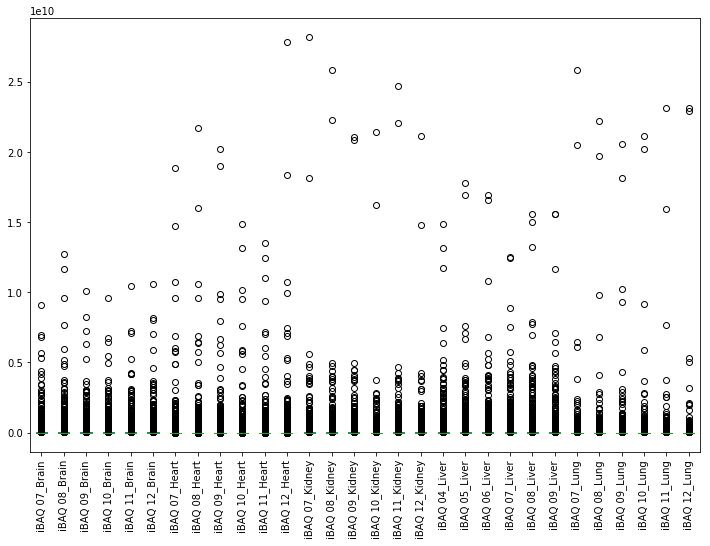

In [455]:
#########################
#
# Unnormalized data abundances 
#
#########################

# Group columns by organ so x-axis will also be grouped
iBAQ_df = iBAQ_df[['Majority protein IDs'] + brain_col_names + heart_col_names + kidney_col_names + liver_col_names + lung_col_names]

iBAQ_df.plot(kind='box', return_type='axes', figsize=(12,8))
plt.xticks(rotation='vertical')
plt.show()

In [456]:
#########################
#
# log2 normalize
#
#########################

iBAQ_df.iloc[:,1:] = iBAQ_df.iloc[:,1:].applymap(np.log2)

print(iBAQ_df.head())

# log2(0) returns -inf; replace with NaN to avoid skewing data
iBAQ_df.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4451: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.asobject, func)


  Majority protein IDs  iBAQ 07_Brain  iBAQ 08_Brain  iBAQ 09_Brain  \
0          1433B_MOUSE      29.897295      29.850685      29.509337   
1          1433E_MOUSE      29.804751      30.438967      29.688125   
2          1433F_MOUSE      29.412036      29.154532      29.276819   
3          1433G_MOUSE      30.647616      30.379375      30.266065   
4          1433S_MOUSE      28.918036      28.992751      28.983974   

   iBAQ 10_Brain  iBAQ 11_Brain  iBAQ 12_Brain  iBAQ 07_Heart  iBAQ 08_Heart  \
0      29.094665      29.821559      29.712026      25.702398      25.617593   
1      29.719928      30.074697      30.296907      27.074799      26.930328   
2      29.065045      29.366822      29.403995      24.583883      24.376236   
3      30.238656      30.261477      30.357938      26.637961      26.518558   
4      28.582441      28.746568      28.906213      25.333199      25.168826   

   iBAQ 09_Heart      ...       iBAQ 06_Liver  iBAQ 07_Liver  iBAQ 08_Liver  \
0      25.876

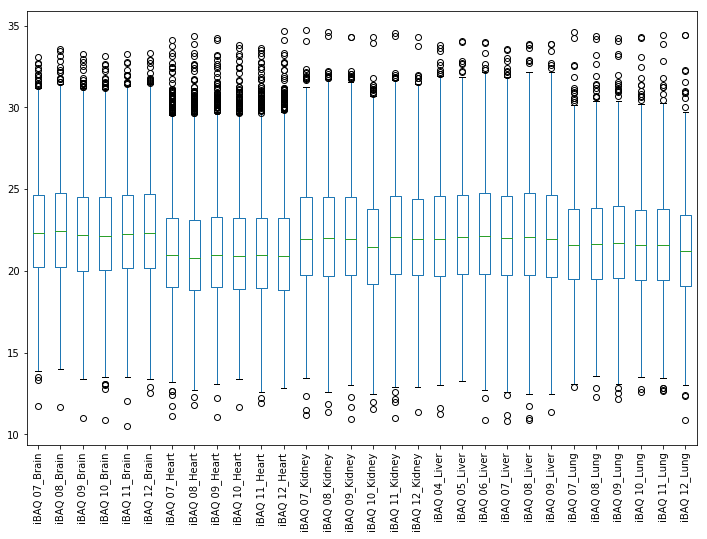

In [457]:
#########################
#
# log2 transformed distribution 
#
#########################

iBAQ_df.plot(kind='box', return_type='axes', figsize=(12,8))
plt.xticks(rotation='vertical')
plt.show()

In [458]:
#########################
#
# Median normalize
#
#########################

iBAQ_quants = iBAQ_df.iloc[:,1:] # Split off iBAQ columns to process
iBAQ_median_of_medians = iBAQ_quants.median().median()

iBAQ_quants /= iBAQ_quants.median(axis=0) # divide each value by sample median
iBAQ_quants *= iBAQ_median_of_medians # multiply each value by median of medians

iBAQ_df.iloc[:,1:] = iBAQ_quants # insert processed iBAQ values into original df
print(iBAQ_df.head())

  Majority protein IDs  iBAQ 07_Brain  iBAQ 08_Brain  iBAQ 09_Brain  \
0          1433B_MOUSE      29.381916      29.224766      29.202234   
1          1433E_MOUSE      29.290967      29.800712      29.379161   
2          1433F_MOUSE      28.905022      28.543210      28.972135   
3          1433G_MOUSE      30.119303      29.742370      29.951087   
4          1433S_MOUSE      28.419538      28.384821      28.682338   

   iBAQ 10_Brain  iBAQ 11_Brain  iBAQ 12_Brain  iBAQ 07_Heart  iBAQ 08_Heart  \
0      28.866554      29.381840      29.233520      26.925319      27.069953   
1      29.486915      29.631245      29.808981      28.363019      28.457112   
2      28.837166      28.933808      28.930450      25.753586      25.758219   
3      30.001576      29.815271      29.869030      27.905397      28.021998   
4      28.358346      28.322699      28.440684      26.538554      26.595744   

   iBAQ 09_Heart      ...       iBAQ 06_Liver  iBAQ 07_Liver  iBAQ 08_Liver  \
0      27.099

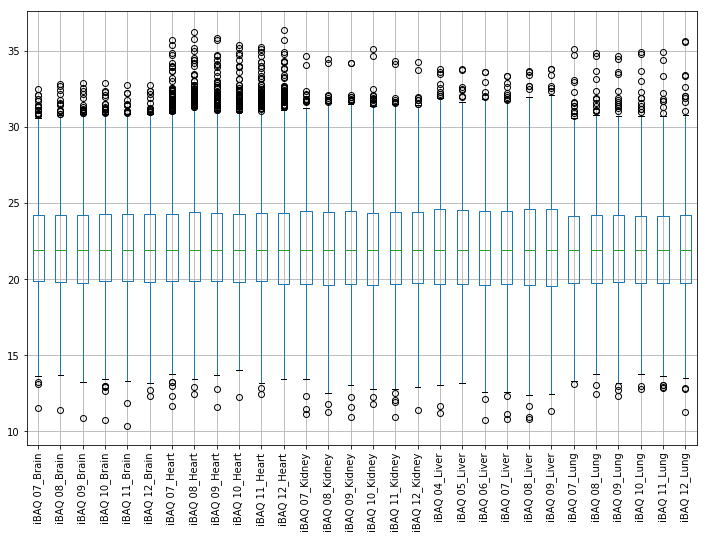

In [459]:
#########################
#
# Median normalized log2 data distribution 
#
#########################

iBAQ_df.boxplot(return_type='axes', figsize=(12,8))
plt.xticks(rotation='vertical')
plt.show()

In [460]:
#########################
#
# Impute missing values
#
#########################

print(iBAQ_df.isnull().values.any()) # Should return true if any nulls are present

iBAQ_min = iBAQ_quants.min().min()
iBAQ_impute_val = iBAQ_min/2

iBAQ_df = iBAQ_df.fillna(iBAQ_impute_val)

print(iBAQ_df.isnull().values.any()) # Should return false if nulls have been replaced

True
False


## PCA

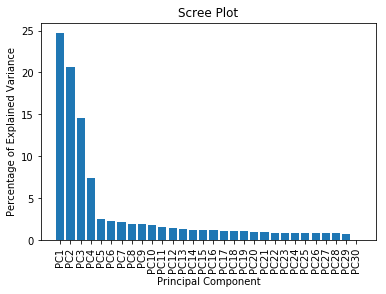

In [461]:
#########################
#
# Perform PCA on the data
#
#########################

iBAQ_df.set_index('Majority protein IDs', inplace=True)
scaled_data = preprocessing.scale(iBAQ_df.T)

pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
#pca.fit(iBAQ_df) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe
 
#########################
#
# Draw a scree plot 
#
#########################
 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.xticks(rotation='vertical')
plt.show()


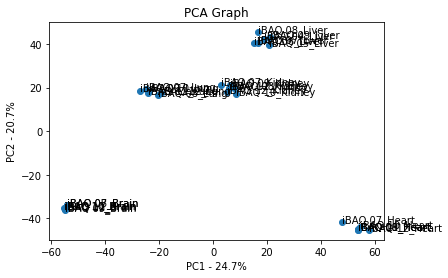

In [462]:
#########################
#
# Draw PCA Graph 
#
#########################

pca_df = pd.DataFrame(pca_data, index=[iBAQ_df.columns.values.tolist()], columns=labels)
 
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
 
plt.show()

## ANOVA and t-tests

In [ ]:
# Extract individual groups

# Perform ANOVA

## Generate Images
* Hierarchical clustering
* Heatmap
* PCA
* Pearson Correlation